# Background

Banks receive thousands of customer inquiries daily through various channels such as call centers, chatbots, and emails. These inquiries cover a range of topics, including account issues, transactions, credit cards, fraud, and technical support. Manually sorting and responding to these inquiries takes time, increases operational costs, and affects customer satisfaction.

To improve efficiency, automated classification of customer inquiries using machine learning and NLP (Natural Language Processing) can help route queries to the right department and provide faster responses.

# Problem Satement

Banks struggle with handling and categorizing customer inquiries efficiently, leading to delays, misrouting, and increased operational costs. The goal of this project is to develop a machine learning-based system to automatically classify customer inquiries into predefined categories (e.g., Billing, Account Access, Fraud, Loan Services, etc.) based on text analysis of customer interactions.

This system will leverage SBERT embeddings and clustering (DBSCAN) for topic discovery, followed by classification models (Logistic Regression, SVM, XGBoost, etc.) to accurately categorize new inquiries. The expected outcome is a system that reduces manual effort, improves response times, and enhances customer satisfaction.

>[Background](#scrollTo=meClH-P1Xv08)

>[Problem Satement](#scrollTo=fiqoKQkpYCr1)

>>[Imports](#scrollTo=Hyc_RPCyesey)

>>[Preprocessing and Exploratory Data Analysis (EDA)](#scrollTo=BzheTpbae2dt)

>>>[Load Data](#scrollTo=8380ueG8fAbq)

>>>[Cleaning The Data](#scrollTo=r1THWJ7UfUma)

>>>[Preprocess The Utterance](#scrollTo=IjL7E7DEUXvF)

>>>[Sentiment Analysis](#scrollTo=WtLx7yvFSRUi)

>>>[Vectorize The Text](#scrollTo=3GRWbCxLSfTW)

>>[Save The Final Dataset](#scrollTo=fXzkhOaVVB95)

>>[Summary](#scrollTo=HQX1MrYhVGgh)



## Imports

In [1]:
# Import

!pip install nltk
!pip install spacy
!pip install transformers
!pip install beautifulsoup4

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#import spacy
#from transformers import pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import re
import uuid

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Preprocessing and Exploratory Data Analysis (EDA)

### Load Data

In [3]:
# Define the dataset path
data_path = 'drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/finance.tsv'

In [4]:
# Load the dataset
df = pd.read_csv(data_path, sep=',')

In [5]:
# Display the size of the dataset: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}\n\n")
df.head()

Number of features: 5




,conversationId,turnNumber,utteranceId,utterance,authorRole
0,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,0,acs-1757d840-5853-4752-b88d-d784e6ba5832,"Hello there, how may I help you today?",agent
1,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,1,acs-b9b6db75-b552-4704-a74f-d7c38b3c40c1,Hi....i need to check my balance,customer
2,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,2,acs-1539335e-cf44-4de9-b737-b2b347919fe9,"Sure thing, could you please help me out with ...",agent
3,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,3,acs-888ed142-16ad-466f-b2d5-66aec7095929,7766,customer
4,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,4,acs-96d4bda7-3de8-4eb6-a0d5-167e5d8684fe,Could you also please help me with your full n...,agent


In [6]:
# Ckeck the details of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157229 entries, 0 to 157228
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   conversationId  157229 non-null  object
 1   turnNumber      157229 non-null  int64 
 2   utteranceId     157229 non-null  object
 3   utterance       157221 non-null  object
 4   authorRole      157229 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [7]:
# Rename the columns
df = df.rename(columns = {'conversationId': 'conversation_id', 'turnNumber': 'turn_number',
                          'utteranceId': 'utterance_id', 'authorRole': 'author_role'})
df.head()

,conversation_id,turn_number,utterance_id,utterance,author_role
0,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,0,acs-1757d840-5853-4752-b88d-d784e6ba5832,"Hello there, how may I help you today?",agent
1,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,1,acs-b9b6db75-b552-4704-a74f-d7c38b3c40c1,Hi....i need to check my balance,customer
2,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,2,acs-1539335e-cf44-4de9-b737-b2b347919fe9,"Sure thing, could you please help me out with ...",agent
3,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,3,acs-888ed142-16ad-466f-b2d5-66aec7095929,7766,customer
4,acs-2ac493ed-4dfb-4c61-9d52-55cd8a673834-1,4,acs-96d4bda7-3de8-4eb6-a0d5-167e5d8684fe,Could you also please help me with your full n...,agent


In [8]:
# Sample conversation
df[df['conversation_id'] == 'acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1']

,conversation_id,turn_number,utterance_id,utterance,author_role
85071,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,0,acs-55bd3d5e-4abf-4fbb-9c07-9623e1a91b39,"Hey there, how may I help you today?",agent
85072,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,1,acs-dd9c4230-5c1a-45b0-90af-16dbdd6cd9de,"Hi, I want to change the address associated wi...",customer
85073,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,2,acs-df9c37a9-9e52-4899-87e7-6d0d72ab0075,I'll be glad to assist you with that.,agent
85074,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,3,acs-2e6054f8-6ff4-4b0c-949e-8b742ab64c5c,May I know your name please?,agent
85075,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,4,acs-2aefb4e8-4ce3-4b58-9f73-b201c56f87a0,Raju,customer
85076,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,5,acs-15fce635-3a0a-4b0a-9c1a-443515f801e5,"Thank you Raju, Could you let me know the last...",agent
85077,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,6,acs-6e763256-e209-40f3-a63d-2841dd84e0b9,5874 and 3698,customer
85078,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,7,acs-41bcd0e2-4b4e-4440-9d3a-50127ebbea96,May I know your new address as well?,agent
85079,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,8,acs-a463427b-d6f8-4f27-8a05-562ac62430e0,"1/354, sakthi street, IN",customer
85080,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,9,acs-2a819370-eb62-4b60-b32c-c3a663406e52,Awesome! Kindly give me a minute.,agent


In [9]:
# Number of conversations
num_of_conversations = df['conversation_id'].nunique()
print(f"Number of conversations: {num_of_conversations}")

Number of conversations: 8832


### Cleaning The Data

In [10]:
# Check the null values
df.isna().sum()

,0
conversation_id,0
turn_number,0
utterance_id,0
utterance,8
author_role,0


In [11]:
# Remove the null values and unusefull columns
dfn = df.dropna().drop(columns=['utterance_id'])

In [12]:
# Convert the relavent columns to lower case
columns = ['conversation_id', 'utterance', 'author_role']
for col in columns:
  dfn[col] = dfn[col].str.lower()

**Get the longest and shortest conversation based on the interactions between the agent and the customer**

In [13]:
# Group by coversation id and get the maximum turnNumber
conversation_lengths = df.groupby('conversation_id')['turn_number'].max()

# Find the conversation with the minimum turnNumber
shortest_conversation = conversation_lengths.idxmin()

# Get the length of the shortest conversation based on the number of interactions
shortest_conversation_length = conversation_lengths.min()

# Find the conversation with the maximum turnNumber
longest_conversation = conversation_lengths.idxmax()

# Get the length of the longest conversation based on the number of interactions
longest_conversation_length = conversation_lengths.max()

# Print the results
print(f"The conversation with the shortest interactions is:{shortest_conversation}")
print(f"The length of the shortest conversation based on interactions is: {shortest_conversation_length}")
print(f"The conversation with the longest interactions is: {longest_conversation}")
print(f"The length of the longest conversation based on interactions is: {longest_conversation_length}")



The conversation with the shortest interactions is:acs-0ab82bc5-670a-4d1d-9aaa-c6b84182be3d-1
The length of the shortest conversation based on interactions is: 0
The conversation with the longest interactions is: acs-1f9bad0a-a0e0-4e42-80b0-ec9ba798e2ef-1
The length of the longest conversation based on interactions is: 45


In [14]:
# Count the conversations based on their id
dfn['conversation_id'].value_counts()

,count
conversation_id,
acs-1f9bad0a-a0e0-4e42-80b0-ec9ba798e2ef-1,46
acs-13716e19-ef69-469d-998a-a74270a4eb49-1,43
acs-a1027f21-8833-4a94-bb43-c88685c73093-1,43
acs-1038c613-6f72-4bd7-9d1c-f9058425debf-1,43
acs-c572e002-ecf8-4035-9f62-4da27f850eea-1,43
...,...
acs-b3dc2829-c832-447c-8168-4431c853161a-1,1
acs-5488a6a6-74dd-4f46-8f85-7102fcf456e3-1,1
acs-b59c5384-758a-49ed-921c-bf57761579e2-1,1


Text(0, 0.5, 'Frequency')

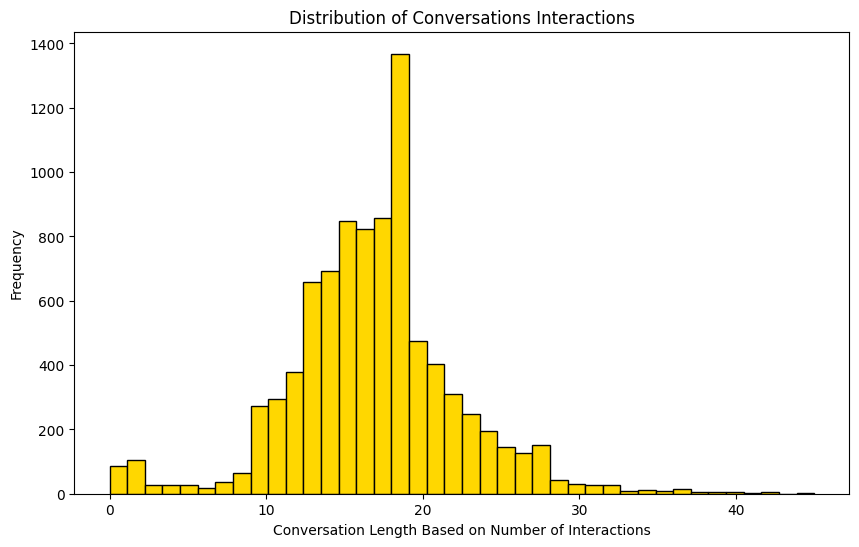

In [15]:
# Plot the distrubion of conversations
plt.figure(figsize=(10, 6))
plt.hist(conversation_lengths, bins=40, color='gold', edgecolor='black')
plt.title('Distribution of Conversations Interactions')
plt.xlabel('Conversation Length Based on Number of Interactions')
plt.ylabel('Frequency')

### Preprocess The Utterance

In [16]:
# Remove HTML tags
# While we have live conversations in our dataset, there might be still html tags if it's the system generated messages
tags_list = ['<p>' ,'</p>' , '<p*>',
             '<ul>','</ul>',
             '<li>','</li>',
             '<br>',
             '<strong>','</strong>',
             '<span*>','</span>',
             '<a href*>','</a>',
             '<em>','</em>']

for tag in tags_list:
  dfn['utterance'].replace(to_replace=tag, value='', regex=True, inplace=True)

<ipython-input-16-7f3bae2eec35>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfn['utterance'].replace(to_replace=tag, value='', regex=True, inplace=True)


In [17]:
# Function for preprocessing
def preprocess(t):
  t = str(t).lower().strip()
  t = t.replace('$', 'dollar')
  t = t.replace('₹', 'rupee')
  t = t.replace('€', 'euro')
  t = t.replace('%', 'percent')
  t = t.replace('@', 'at')
  t = t.replace(', 000,000,000', 'b ')
  t = t.replace(', 000,000', 'm ')
  t = t.replace(', 000', 'k ')
  t = re.sub(r'([0-9]+)000000000', r'\1b', t)
  t = re.sub(r'([0-9]+)000000', r'\1m', t)
  t = re.sub(r'([0-9]+)000', r'\1k', t)

  # Decontracting words
  contractions = {
  "ain't": "am not",
  "can't": "cannot",
  "can't've": "cannot have",
  "cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he had / he would",
  "he'd've": "he would have",
  "he'll": "he shall / he will",
  "he'll've": "he shall have / he will have",
  "he's": "he has / he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how has / how is / how does",
  "I'd": "I had / I would",
  "I'd've": "I would have",
  "I'll": "I shall / I will",
  "I'll've": "I shall have / I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had / it would",
  "it'd've": "it would have",
  "it'll": "it shall / it will",
  "it'll've": "it shall have / it will have",
  "it's": "it has / it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she shall / she will",
  "she'll've": "she shall have / she will have",
  "she's": "she has / she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as / so is",
  "that'd": "that would / that had",
  "that'd've": "that would have",
  "that's": "that has / that is",
  "there'd": "there had / there would",
  "there'd've": "there would have",
  "there's": "there has / there is",
  "they'd": "they had / they would",
  "they'd've": "they would have",
  "they'll": "they shall / they will",
  "they'll've": "they shall have / they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had / we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what shall / what will",
  "what'll've": "what shall have / what will have",
  "what're": "what are",
  "what's": "what has / what is",
  "what've": "what have",
  "when's": "when has / when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where has / where is",
  "where've": "where have",
  "who'll": "who shall / who will",
  "who'll've": "who shall have / who will have",
  "who's": "who has / who is",
  "who've": "who have",
  "why's": "why has / why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you shall have / you will have",
  "you're": "you are",
  "you've": "you have"
  }

  t_decontracted = []

  for word in t.split():
      if word in contractions:
          word = contractions[word]
      t_decontracted.append(word)

  t = ' '.join(t_decontracted)
  t = t.replace("'ve", " have")
  t = t.replace("n't", " not")
  t = t.replace("'re", " are")
  t = t.replace("'ill", " will")

  # Remove punctuations
  t = re.sub(r'[^\w\s]', '', t)

  # Remove extra spaces and leading/trailing spaces
  t = re.sub(r'\s+', ' ', t).strip()

  return t

In [18]:
# Executing the preprocess function on related columns
columns = ['utterance']
for col in columns:
  dfn[col] = dfn[col].apply(preprocess)

**Lemmatization for reducing words to their base or root form to improve text consistency and enhance clustering and classification accuracy.**

In [19]:
# Remove stop words and lemmatizing the words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

dfn['utterance'] = dfn['utterance'].apply(remove_stopwords_and_lemmatize)

**Combine all utterances of each conversation**

In [20]:
# Add a unique turn ID to each utterance
dfn['turn_id'] = dfn.groupby('conversation_id').cumcount() + 1
dfn['utterance'] = dfn['author_role'] + ': ' + dfn['utterance']  # Add author role to distinguish turns

# Define a custom aggregation function to combine utterances with turn IDs
def combine_utterances(group):
  turns = group.sort_values(by='turn_id')['utterance'].tolist()
  return ' '.join(turns)

# Combine the utterance of authors in each conversation and put them in one row
dfn = dfn.groupby('conversation_id').apply(combine_utterances).reset_index(name='utterance')

# see the full dataset context
pd.set_option('display.max_colwidth', None)

print(dfn.shape)
dfn.head()

(8832, 2)


<ipython-input-20-0590ef31b7d0>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfn = dfn.groupby('conversation_id').apply(combine_utterances).reset_index(name='utterance')


,conversation_id,utterance
0,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,agent: hey may help today customer: hi want change address associated credit card agent: ill glad assist agent: may know name please customer: raju agent: thank raju could let know last 4 digit ssn last 4 digit account number please customer: 5874 3698 agent: may know new address well customer: 1354 sakthi street agent: awesome kindly give minute customer: ya sure agent: thank much staying connected address updated shall receive bank alert updated address customer: hmmm ok agent: may know concern customer: concern thanks effort agent: thank reaching u pleasure assisting
1,acs-000e0b37-c8f0-46fe-9ffb-0c727e888339-1,agent: hellohow may help today customer: hi need help remove unwanted charge credit card got error report credit card bill agent: oh im sorry hear ill definitely help ensure repeated customer: ok detail required clear issue agent: may please know first last name customer: fill name clement customer: full name clement agent: awesome also may please know last four digit ssn customer: last four digit ssn number 7883 agent: id also require complete credit card number customer: credit card number 73156899867983 agent: thank could help date amount charge customer: charged amount dollar65 date 05172018 time 130 pm agent: thank much bringing notice ill ensure ill raise request delete charge kindly give u 2448 hour get resolved also receiving confirmation email resolved customer: ok thanks agent: welcome would anything else may help customer: yesneed change new address saving account agent: sure may know new address customer: new address 85 five way building newly new film street dc agent: hank sharing information processed request change address shall shortly receive confirmation email customer: ok thanks agent: welcome may confirm question answered today customer: yes thanks timely support agent: always pleasure assisting valuable customer like great day ahead looking forward seeing soon customer: thanks agent: goodbye customer: goodbye
2,acs-000efddb-1d74-4422-808e-1b4ccbf988f1-1,customer: good morning agent: good morning may help today customer: lost card safe money agent: sure worry money safe could please help full name credit card number last 4 digit ssn customer: amulassn5240credit card number5426842765274162 agent: okay amul could also please tell card last used police report filed customer: 06272018time1927i file report agent: good know registered complaint please give moment go ahead block card customer: sure waiting agent: thank patient would like inform successfully blocked card issued new one delivered within 23 business day customer: thanks information agent: welcome anything else may assist customer: got enough informationthank agent: awesome thank much cooperation great day
3,acs-001df2c1-5318-4715-8d99-7ece76c95fa2-1,agent: hello customer: hello jamie customer: najma agent: good morning may assist today customer: good morning customer: want change address associated credit card agent: sure thing may know card number please customer: yes course agent: yes please customer: 7854263914236743 agent: perfect may also know last four digit ssn customer: 7599 agent: awesome may know new address update customer: customer: 101 paragon drive montvale nj 07645 agent: great gone ahead updated new address convenience customer: sorry made mistake new address agent: yes please go customer: possible change agent: yeah sure customer: possible change agent: yes may know correct address customer: please change 101 201 customer: 201 paragon drive montvale nj 07645 correct address agent: address successfully updated customer: ohthank agent: great always pleasure assisting valuable customer like great day ahead
4,acs-002c64ef-f434-41cd-8c36-39c4d8b9cd30-1,customer: hi agent: hello may help today customer: want transfer money another account agent: would glad help regard may know name please customer: edison agent: thanks edison pull information require last 4 d

### Sentiment Analysis

VADER is a lexicon-based sentiment analysis tool designed for short text, like customer inquiries. It assigns a sentiment score to text, categorizing it as:

- Positive (score > 0)
- Neutral (score = 0)
- Negative (score < 0)

In [21]:
# Get the sentiment scors of each utterance and add the new feature "sentiment_score"
analyzer = SentimentIntensityAnalyzer()

dfn['sentiment_score'] = dfn['utterance'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

dfn.head()

,conversation_id,utterance,sentiment_score
0,acs-00051ccd-7f2b-4b4d-85dc-f716c7e9f34f-1,agent: hey may help today customer: hi want change address associated credit card agent: ill glad assist agent: may know name please customer: raju agent: thank raju could let know last 4 digit ssn last 4 digit account number please customer: 5874 3698 agent: may know new address well customer: 1354 sakthi street agent: awesome kindly give minute customer: ya sure agent: thank much staying connected address updated shall receive bank alert updated address customer: hmmm ok agent: may know concern customer: concern thanks effort agent: thank reaching u pleasure assisting,0.9896
1,acs-000e0b37-c8f0-46fe-9ffb-0c727e888339-1,agent: hellohow may help today customer: hi need help remove unwanted charge credit card got error report credit card bill agent: oh im sorry hear ill definitely help ensure repeated customer: ok detail required clear issue agent: may please know first last name customer: fill name clement customer: full name clement agent: awesome also may please know last four digit ssn customer: last four digit ssn number 7883 agent: id also require complete credit card number customer: credit card number 73156899867983 agent: thank could help date amount charge customer: charged amount dollar65 date 05172018 time 130 pm agent: thank much bringing notice ill ensure ill raise request delete charge kindly give u 2448 hour get resolved also receiving confirmation email resolved customer: ok thanks agent: welcome would anything else may help customer: yesneed change new address saving account agent: sure may know new address customer: new address 85 five way building newly new film street dc agent: hank sharing information processed request change address shall shortly receive confirmation email customer: ok thanks agent: welcome may confirm question answered today customer: yes thanks timely support agent: always pleasure assisting valuable customer like great day ahead looking forward seeing soon customer: thanks agent: goodbye customer: goodbye,0.9977
2,acs-000efddb-1d74-4422-808e-1b4ccbf988f1-1,customer: good morning agent: good morning may help today customer: lost card safe money agent: sure worry money safe could please help full name credit card number last 4 digit ssn customer: amulassn5240credit card number5426842765274162 agent: okay amul could also please tell card last used police report filed customer: 06272018time1927i file report agent: good know registered complaint please give moment go ahead block card customer: sure waiting agent: thank patient would like inform successfully blocked card issued new one delivered within 23 business day customer: thanks information agent: welcome anything else may assist customer: got enough informationthank agent: awesome thank much cooperation great day,0.9926
3,acs-001df2c1-5318-4715-8d99-7ece76c95fa2-1,agent: hello customer: hello jamie customer: najma agent: good morning may assist today customer: good morning customer: want change address associated credit card agent: sure thing may know card number please customer: yes course agent: yes please customer: 7854263914236743 agent: perfect may also know last four digit ssn customer: 7599 agent: awesome may know new address update customer: customer: 101 paragon drive montvale nj 07645 agent: great gone ahead updated new address convenience customer: sorry made mistake new address agent: yes please go customer: possible change agent: yeah sure customer: possible change agent: yes may know correct address customer: please change 101 201 customer: 201 paragon drive montvale nj 07645 correct address agent: address successfully updated customer: ohthank agent: great always pleasure assisting valuable customer like great day ahead,0.9961
4,acs-002c64ef-f434-41cd-8c36-39c4d8b9cd30-1,customer: hi agent: hello may help today customer: want transfer money another account agent: would glad help regard may know name please customer: edison agent: tha

Text(0, 0.5, 'Number of Conversations')

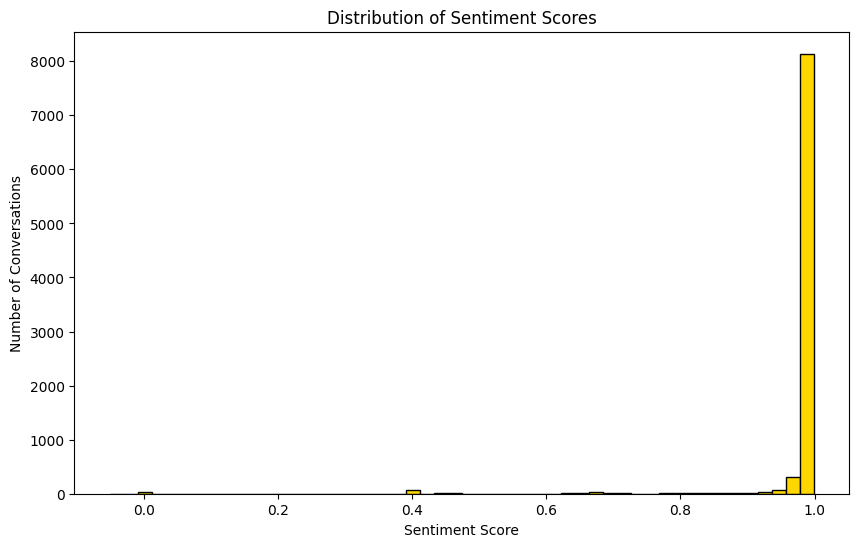

In [22]:
# Plot the number of conversatioins based on the sentiment score
plt.figure(figsize=(10, 6))
plt.hist(dfn['sentiment_score'], bins=50, color='gold', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Conversations')

In [23]:
# Define a new dataframe which includes negative sentiment with lower ratings
df_neg_sent = dfn[(dfn['sentiment_score'] <0)]

df_neg_sent

,conversation_id,utterance,sentiment_score
938,acs-1ae9f14f-747f-43a7-bb2f-1011d5c08063-1,agent: hello good morning may assist today agent: hey connected agent: since reply end forced end conversation,-0.0258
2026,acs-393bc1e5-564a-4666-9a59-0dbc85a84ac1-1,agent: hey may help agent: hope still connected response ill forced close chat 30 second,-0.0516


### Vectorize The Text

The resulting plot can provide insights into the most frequent words. By having this plot we could see that most conversations have credit card, address and account words.

Number of tokens after applying CountVectorizer on Utterance: 299365


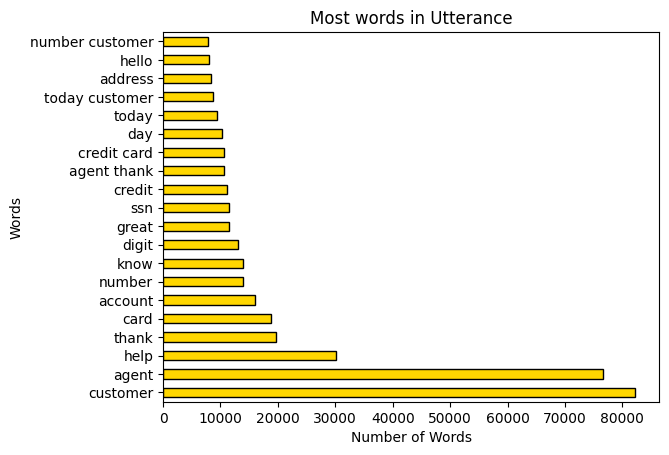

In [24]:
# Find the highest number of words in utterance
X = dfn['utterance']
cvec = CountVectorizer(stop_words="english", ngram_range=(1, 3))
cvec.fit(X)
X = cvec.transform(X)

# convert X to dataframe
df_vec = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
print(f"Number of tokens after applying CountVectorizer on Utterance: {df_vec.shape[1]}")

# plot the most occured words
df_vec.sum().sort_values(ascending=False).head(20).plot(kind="barh",
                        color = 'gold', edgecolor = "black")
plt.title(f"Most words in Utterance", fontsize=12)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Words", fontsize=10);

## Save The Final Dataset

In [25]:
# Save the new dataset
dfn.to_csv('drive/MyDrive/Colab_Notebooks/financial_customer_inq/data/cleaned_data.csv', index=False)

## Summary

This notebook prepares customer inquiries for categorization by cleaning, analyzing, and transforming the data.

- Removed HTML tags, stopwords, punctuation, and lemmatized text.
- Identified the longest and shortest conversations based on interactions.
- Used VADER to classify inquiries as positive, neutral, or negative.
- Found the most common words per conversation using CountVectorizer.
- Analyzed the number of interactions per conversation.